In [6]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
#hide
from fastai.vision.all import *
from fastbook import *
matplotlib.rc('image', cmap='Greys')

In [7]:
path = untar_data(URLs.MNIST_SAMPLE)


In [8]:
Path.BASE_PATH = path

In [9]:
sevens = (path/'train/7').ls()
threes = (path/'train/3').ls()
sevens_stack = torch.stack([tensor(Image.open(o)) for o in sevens]).float() / 255
threes_stack = torch.stack([tensor(Image.open(o)) for o in threes]).float() / 255


In [10]:
mean7 = sevens_stack.mean(0)
mean3 = threes_stack.mean(0)


In [11]:
def minst_dist(a, b): return (a - b).abs().mean()

In [12]:
def is_3(o): return minst_dist(o, mean3) < minst_dist(o, mean7)

In [13]:
is_3(sevens_stack[3])

tensor(False)

In [14]:
valid_sevens_stack = torch.stack([tensor(Image.open(o)) for o in (path/'valid/7').ls()]).float() / 255
valid_threes_stack = torch.stack([tensor(Image.open(o)) for o in (path/'valid/3').ls()]).float() / 255


In [15]:
(sum(1 - is_3(o).float() for o in valid_sevens_stack) / len(valid_sevens_stack),
sum(is_3(o).float() for o in valid_threes_stack) / len(valid_threes_stack))


(tensor(0.9854), tensor(0.9168))

In [16]:
def f(x): return x**2


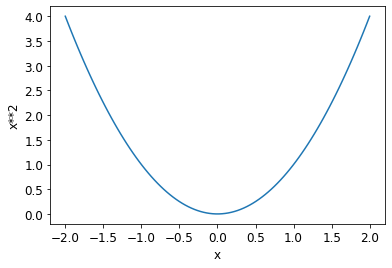

In [18]:
plot_function(f, 'x', 'x**2')

In [33]:
xt = tensor(3.).requires_grad_()  # 

In [34]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

In [35]:
yt.backward()


In [36]:
yt

tensor(9., grad_fn=<PowBackward0>)

In [37]:
xt.grad

tensor(6.)